In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
from keras.models import Sequential
from tensorflow import keras
import seaborn as sn

In [2]:
# All mfcc data are contained in numpy_datas, which is a list. 
# The each entry of the list is another list consistes of [mfccs, file name]
MFCCs_DATA = "MFCCsData"
numpy_datas = []

dirlist = os.listdir(MFCCs_DATA)
for d in dirlist:
    d = os.path.join(MFCCs_DATA, d)
    datalist = os.listdir(d)
    datalist = [[np.load(os.path.join(d,x)), os.path.join(d,x)] for x in datalist]
    numpy_datas.extend(datalist)

In [3]:
# find the max size of mfcc and use it to reshape all mfccs into the same shape
mfcc_size = []
for i in range(len(numpy_datas)):
    mfcc_size.append(numpy_datas[i][0].shape[1])
max(mfcc_size)

1841

In [4]:
# resize into (19,1841) and flatten into (19*1841,1)
for i in range(len(numpy_datas)):
    numpy_datas[i][0] = np.resize(np.resize(numpy_datas[i][0], (19,1841)), (19*1841,1))

In [5]:
numpy_datas[i][0].shape

(34979, 1)

In [6]:
# change file name to correct label
angry = []
happy = []
normal = []

for i in range(len(numpy_datas)):
    file_name = numpy_datas[i][1]
    if "angry" in file_name:
        numpy_datas[i][1] = np.array([1,0,0])
        angry.append(numpy_datas[i])
    elif "happy" in file_name:
        numpy_datas[i][1] = np.array([0,1,0])
        happy.append(numpy_datas[i])
    else:
        numpy_datas[i][1] = np.array([0,0,1])
        normal.append(numpy_datas[i])

In [7]:
# first shuffle the list of each emotion
random.shuffle(angry)
random.shuffle(happy)
random.shuffle(normal)

In [8]:
# then select the first 180 in each emotion as train data, first 60 in each emotion as valid data, and first 60 in each emotion as test data
train_data = angry[:int(len(angry)*0.6)] + happy[:int(len(happy)*0.6)] + normal[:int(len(normal)*0.6)]
valid_data = angry[int(len(angry)*0.6):int(len(angry)*(0.6+0.2))] + happy[int(len(happy)*0.6):int(len(happy)*(0.6+0.2))] + normal[int(len(normal)*0.6):int(len(normal)*(0.6+0.2))]
test_data = angry[int(len(angry)*(0.6+0.2)):] + happy[int(len(happy)*(0.6+0.2)):] + normal[int(len(normal)*(0.6+0.2)):]
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [9]:
# train, valid, test data are all in list consistes of [mfccs, file name]
# want to change the list to two outputs:
# X: vector of mfccs
# Y: vector of labels
def data2vector(data):
    X = []
    Y = []
    for i in range(len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [10]:
X_train, Y_train = data2vector(train_data)
X_valid, Y_valid = data2vector(valid_data)
X_test, Y_test = data2vector(test_data)

# calcualte mean and standard deviation
X_train_miu = np.average(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

# normalization
X_train_norm = (X_train - X_train_miu)/X_train_std
X_valid_norm = (X_valid - X_train_miu)/X_train_std
X_test_norm = (X_test - X_train_miu)/X_train_std

In [11]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

Now we build a 3 layer neuronetwork: linear -> relu -> linear -> relu -> linear -> softmax

In [13]:
dnn_model = Sequential()
dnn_model.add(tfl.Dense(16, input_shape=(1841*19,), activation='sigmoid',
                        kernel_initializer='glorot_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )
dnn_model.add(tfl.ReLU())
dnn_model.add(tfl.BatchNormalization())
dnn_model.add(tfl.Dense(8, activation='sigmoid',
                        kernel_initializer='glorot_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )
dnn_model.add(tfl.ReLU())
dnn_model.add(tfl.BatchNormalization())
dnn_model.add(tfl.Dense(3,
                        kernel_initializer='glorot_normal', bias_initializer='zeros',
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
dnn_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                559680    
                                                                 
 re_lu_2 (ReLU)              (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 re_lu_3 (ReLU)              (None, 8)                 0         
                                                                 
 batch_normalization_1 (Batc  (None, 8)                32        
 hNormalization)                                      

In [21]:
history = dnn_model.fit(X_train_norm, Y_train, epochs=100, validation_data=(X_valid_norm, Y_valid))

Epoch 1/100
17/17 [==============================] - 2s 61ms/step - loss: 6.5999 - accuracy: 0.3796 - val_loss: 8.7963 - val_accuracy: 0.3667
Epoch 2/100
17/17 [==============================] - 1s 54ms/step - loss: 6.2266 - accuracy: 0.3815 - val_loss: 8.9492 - val_accuracy: 0.3778
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 6.6090 - accuracy: 0.3981 - val_loss: 9.1117 - val_accuracy: 0.3556
Epoch 4/100
17/17 [==============================] - 1s 53ms/step - loss: 6.4883 - accuracy: 0.3833 - val_loss: 9.1291 - val_accuracy: 0.3778
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 6.4932 - accuracy: 0.3796 - val_loss: 9.3595 - val_accuracy: 0.3778
Epoch 6/100
17/17 [==============================] - 1s 49ms/step - loss: 6.6033 - accuracy: 0.3815 - val_loss: 9.5485 - val_accuracy: 0.3667
Epoch 7/100
17/17 [==============================] - 1s 53ms/step - loss: 6.3579 - accuracy: 0.4056 - val_loss: 9.4258 - val_accuracy: 0.3722
Epoch 

17/17 [==============================] - 1s 49ms/step - loss: 7.7656 - accuracy: 0.4315 - val_loss: 8.8358 - val_accuracy: 0.4056
Epoch 59/100
17/17 [==============================] - 1s 48ms/step - loss: 7.2391 - accuracy: 0.4204 - val_loss: 9.1513 - val_accuracy: 0.4111
Epoch 60/100
17/17 [==============================] - 1s 48ms/step - loss: 7.3639 - accuracy: 0.4259 - val_loss: 9.2402 - val_accuracy: 0.4000
Epoch 61/100
17/17 [==============================] - 1s 41ms/step - loss: 7.4694 - accuracy: 0.4370 - val_loss: 9.1385 - val_accuracy: 0.3944
Epoch 62/100
17/17 [==============================] - 1s 54ms/step - loss: 7.3790 - accuracy: 0.4426 - val_loss: 8.8963 - val_accuracy: 0.3944
Epoch 63/100
17/17 [==============================] - 1s 55ms/step - loss: 7.6218 - accuracy: 0.4278 - val_loss: 8.8811 - val_accuracy: 0.3889
Epoch 64/100
17/17 [==============================] - 1s 49ms/step - loss: 7.2491 - accuracy: 0.4296 - val_loss: 8.8637 - val_accuracy: 0.3833
Epoch 65/100

C:\Users\zhuq6\AppData\Local\Temp\ipykernel_53700\903421272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\zhuq6\AppData\Local\Temp\ipykernel_53700\903421272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

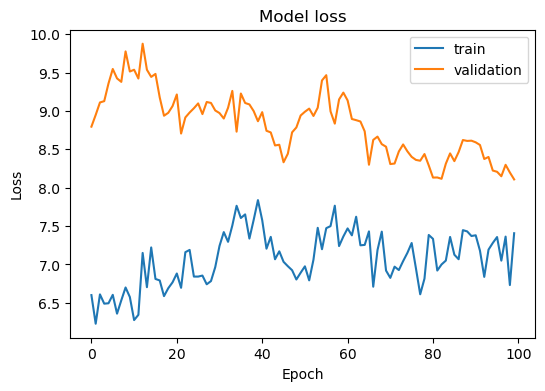

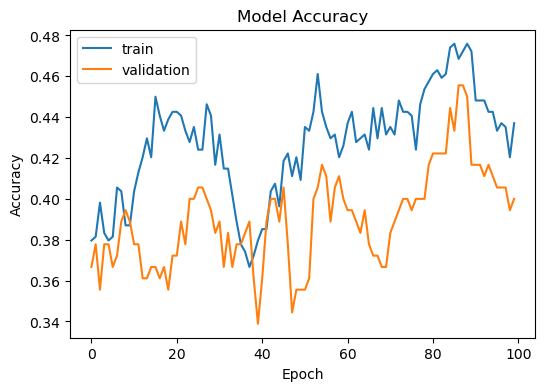

In [22]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

6/6 [==============================] - 0s 10ms/step


[Text(0.5, 23.52222222222222, 'prediction'),
 Text(50.722222222222214, 0.5, 'actual')]

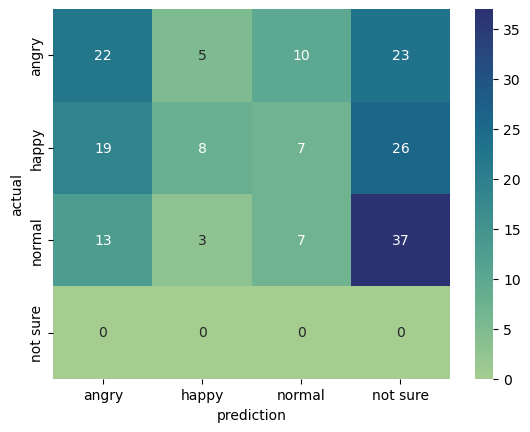

In [23]:
Y_pred = dnn_model.predict(X_test_norm)
Y_test_numpy = Y_test.numpy()
emotion_pred = []
emotion_test = []
for i in range(len(Y_pred)):
    if (Y_pred[i][0] > 0.5):
        emotion_pred.append(0) # angry
    elif (Y_pred[i][1] > 0.5):
        emotion_pred.append(1) # happy
    elif (Y_pred[i][2] > 0.5):
        emotion_pred.append(2) # normal
    else:
        emotion_pred.append(3) # not decided

    if (Y_test_numpy[i][0] > 0.5):
        emotion_test.append(0)
    elif (Y_test_numpy[i][1] > 0.5):
        emotion_test.append(1)
    elif (Y_test_numpy[i][2] > 0.5):
        emotion_test.append(2)

emotion_test = tf.convert_to_tensor(emotion_test)
emotion_pred = tf.convert_to_tensor(emotion_pred)

confusion = tf.math.confusion_matrix(emotion_test, emotion_pred, num_classes = 4)

df=pd.DataFrame(confusion.numpy(),index=['angry', 'happy', 'normal', 'not sure'],columns=['angry', 'happy', 'normal', 'not sure'])
confusiton_map = sn.heatmap(df,annot=True, cmap='crest')
confusiton_map.set(xlabel="prediction", ylabel="actual")